In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
X_train = pd.read_csv('../../data/raw/X_train.csv', parse_dates=['year'])
X_train['year'] = X_train['year'].dt.year
y_train = pd.read_csv('../../data/raw/y_train.csv')
train_df = X_train.join(y_train.set_index('carID'), on="carID")

In [3]:
# separate X and y
X_train, y_train = train_df.drop(columns="price"), train_df["price"]

In [4]:
drop_features = ["carID"]
categorical_features = ["brand", "model", "transmission", "fuelType"]
ordinal_features = ["year"]
target = "price"
numeric_features = list(
    set(train_df.columns)
    - set(drop_features)
    - set(categorical_features)
    - set(ordinal_features)
    - set([target])
)

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore", dtype="int"), categorical_features),
    (OrdinalEncoder(handle_unknown="use_encoded_value",
    unknown_value=np.nan), ordinal_features),
    ("drop", drop_features))

preprocessor.fit(X_train)
pipe_lr = make_pipeline(
    preprocessor, Ridge(random_state=123)
    )


feature_names = (
    numeric_features
    + list(
        pipe_lr.named_steps["columntransformer"]
        .named_transformers_["onehotencoder"]
        .get_feature_names_out()
    )
    + ordinal_features)

X_train_encode = pd.DataFrame(
    data=preprocessor.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index
    )

pipe_xgb = make_pipeline(
    preprocessor, XGBRegressor(random_state=123)
    )

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


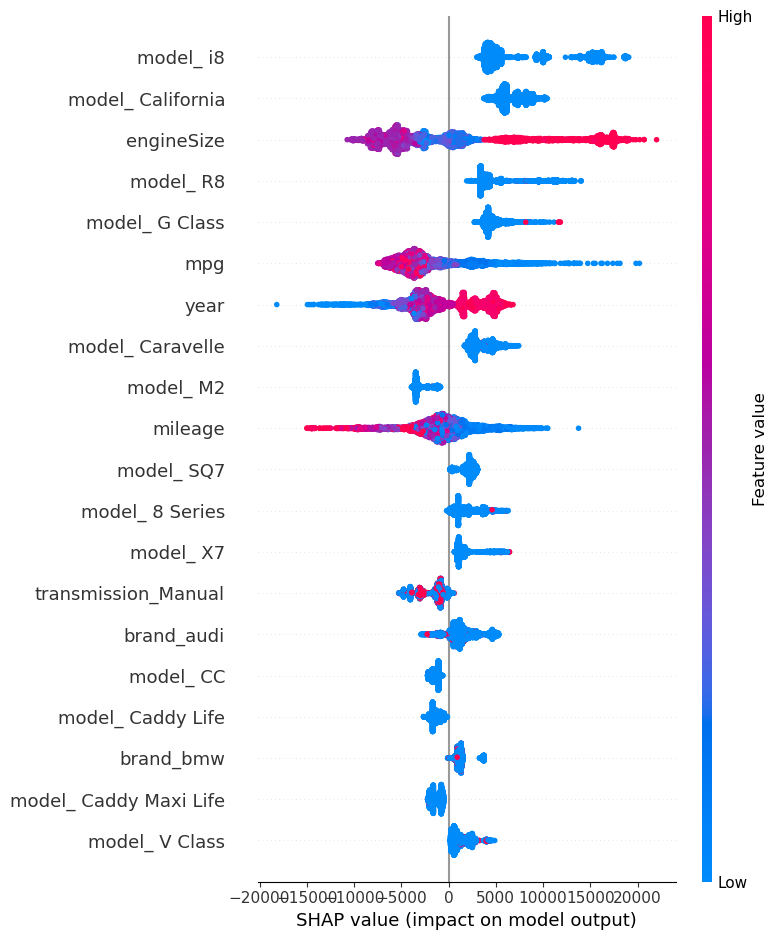

In [5]:
pipe_xgb.fit(X_train, y_train)
xgboost_explainer = shap.TreeExplainer(
pipe_xgb.named_steps["xgbregressor"])
shap_values = xgboost_explainer.shap_values(X_train_encode)

shap.summary_plot(shap_values, X_train_encode, show=False)
plt.savefig('../../results/shap_plot.svg', bbox_inches='tight')